In [1]:
import urllib.request
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

# 1. Reading data

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
filename = 'data.csv'
urllib.request.urlretrieve(url, filename)

('data.csv', <http.client.HTTPMessage at 0x280e88477c0>)

In [3]:
df = pd.read_csv('data.csv', header=0, sep=',')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 2. Data preparation

## 2.1. Filling missed values with 0

In [5]:
series_s = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'
    ]

In [6]:
df = df[series_s]

In [7]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df = df.fillna(0)
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [9]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
df.ocean_proximity = df.ocean_proximity.replace(to_replace='<1H OCEAN', value='LESS_1H_OCEAN')

In [11]:
df.ocean_proximity.value_counts()

LESS_1H_OCEAN    9136
INLAND           6551
NEAR OCEAN       2658
NEAR BAY         2290
ISLAND              5
Name: ocean_proximity, dtype: int64

## 2.2 Setting up the validation framework, application of log tranform to median_house_value

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## 2.3 One-hot encoding

In [15]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [16]:
# check series names
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=INLAND',
       'ocean_proximity=ISLAND', 'ocean_proximity=LESS_1H_OCEAN',
       'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN',
       'population', 'total_bedrooms', 'total_rooms'], dtype=object)

In [17]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

# 3 Train decision tree

In [18]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

### Q1. Which feature is used for splitting the data?

In [19]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\Users\alena\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Answer Q1: ocean_proximity=INLAND

# 4 Random forest

## 4.1 Model creation

In [20]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

### Q2. What's the RMSE of this model on validation?

In [21]:
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_pred, y_val))
round(rmse, 2)

0.25

Answer Q2: 0.25

## 4.2 Parameters tuning

### Q3. Now let's experiment with the n_estimators parameter. Try different values of this parameter from 10 to 200 with step 10. Set random_state to 1. Evaluate the model on the validation dataset. After which value of n_estimators does RMSE stop improving?

In [22]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    
    print("n_estimators = {}   rmse = {:0.3f}".format(n, rmse))
    
    scores.append((n, round(rmse,3)))

n_estimators = 10   rmse = 0.246
n_estimators = 20   rmse = 0.239
n_estimators = 30   rmse = 0.236
n_estimators = 40   rmse = 0.234
n_estimators = 50   rmse = 0.233
n_estimators = 60   rmse = 0.233
n_estimators = 70   rmse = 0.232
n_estimators = 80   rmse = 0.232
n_estimators = 90   rmse = 0.232
n_estimators = 100   rmse = 0.232
n_estimators = 110   rmse = 0.232
n_estimators = 120   rmse = 0.232
n_estimators = 130   rmse = 0.232
n_estimators = 140   rmse = 0.232
n_estimators = 150   rmse = 0.232
n_estimators = 160   rmse = 0.232
n_estimators = 170   rmse = 0.231
n_estimators = 180   rmse = 0.232
n_estimators = 190   rmse = 0.232
n_estimators = 200   rmse = 0.232


In [23]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

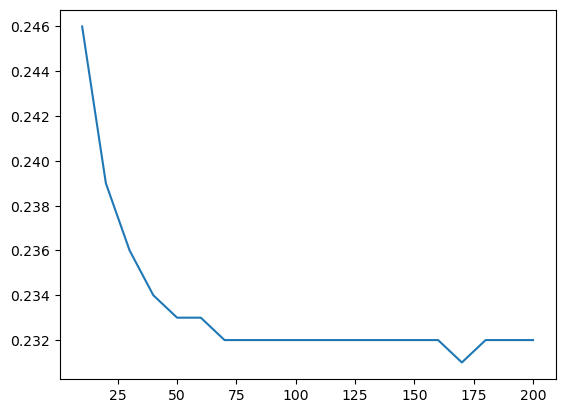

In [24]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

Answer Q3: 70

### Q4 Let's select the best max_depth: Try different values of max_depth: [10, 15, 20, 25] For each of these values, try different values of n_estimators from 10 till 200 (with step 10) Fix the random seed: random_state=1. What's the best max_depth?

In [25]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        #print("d = {}    n_estimators = {}    rmse = {:0.3f}".format(d, n, rmse))
    
        scores.append((d, n, rmse))

In [26]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

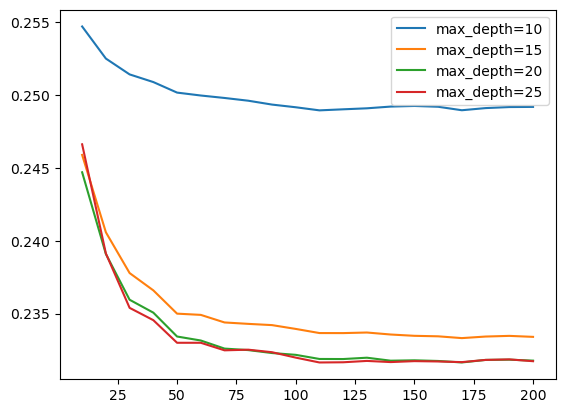

In [27]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

Answer Q4: 25

### Q5 Train the model with these parametes: n_estimators=10, max_depth=20, random_state=1,p n_jobs=-1 (optional). Get the feature importance information from this model. What's the most important feature?

In [28]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [29]:
rf.feature_importances_

array([1.69953548e-02, 3.32350423e-02, 1.01585087e-01, 9.60690809e-02,
       3.63566551e-01, 3.10900842e-01, 3.58443866e-04, 3.05304121e-03,
       3.89846652e-04, 4.15875799e-03, 3.04543473e-02, 1.80449555e-02,
       2.11886497e-02])

In [30]:
df_feature_importances = pd.DataFrame(columns=['feature', 'importance'])
df_feature_importances['feature'] = dv.get_feature_names()
df_feature_importances['importance'] = rf.feature_importances_
df_feature_importances.sort_values('importance', ascending = False, ignore_index=True)

C:\Users\alena\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,median_income,0.363567
1,ocean_proximity=INLAND,0.310901
2,latitude,0.101585
3,longitude,0.096069
4,housing_median_age,0.033235
5,population,0.030454
6,total_rooms,0.021189
7,total_bedrooms,0.018045
8,households,0.016995
9,ocean_proximity=NEAR OCEAN,0.004159


Answer Q5: median_income

# 5 Gradient boosting decision tree model

In [31]:
import xgboost as xgb

C:\Users\alena\anaconda3\envs\ml-zoomcamp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [32]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\alena\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [84]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [85]:
scores= {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
        'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10) 

In [92]:
s = output.stdout

In [93]:
print(s[:100])

[0]	train-rmse:8.12733	val-rmse:8.13245
[10]	train-rmse:0.34481	val-rmse:0.35782
[20]	train-rmse:0.2


In [94]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [95]:
scores['eta=0.1']

,num_iter,train_rmse,val_rmse
0,0,10.44371,10.44938
1,10,3.65741,3.66135
2,20,1.30499,1.31054
3,30,0.51144,0.52189
4,40,0.27985,0.30053
5,50,0.22614,0.25334
6,60,0.21035,0.24189
7,70,0.20116,0.23684
8,80,0.19384,0.23398
9,90,0.18794,0.23206


In [96]:
scores['eta=0.3']

,num_iter,train_rmse,val_rmse
0,0,8.12733,8.13245
1,10,0.34481,0.35782
2,20,0.21580,0.24624
3,30,0.19440,0.23741
4,40,0.17983,0.23419
5,50,0.16934,0.23097
6,60,0.16177,0.22950
7,70,0.15323,0.22787
8,80,0.14564,0.22611
9,90,0.13892,0.22628


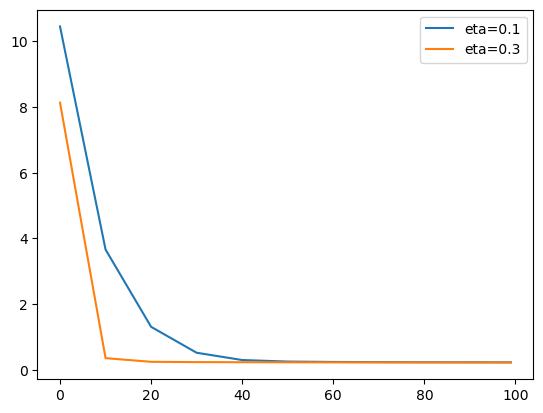

In [97]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()

Answer Q6: 0.3